In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

import pandas as pd
import numpy as np

import time

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

In [2]:
# Load data from the Strava export
# https://support.strava.com/hc/en-us/articles/216918437-Exporting-your-Data-and-Bulk-Export#Bulk
activity_data = pd.read_csv('activities.csv')

# Filter and format data.
activity_data = activity_data[
    (activity_data['type'] == 'Ride') | (activity_data['type'] == 'VirtualRide')
]  # Only cycling.
activity_data['date'] = pd.to_datetime(activity_data['date'])  # Convert to date type.
activity_data['date'] = activity_data['date'].apply(lambda d: d.date())   # Remove time information.
activity_data['unix'] = activity_data['date'].apply(lambda d: time.mktime(d.timetuple()))  # Epoch.

# Make aggregations.
activity_data = activity_data[['unix', 'distance']]  # Select only the epoch time and distance.
activity_data = activity_data.groupby('unix').agg({'distance': np.sum})  # Group by dates. Only one summarized activity per day.

# Format data and more aggregations.
activity_data['unix'] = activity_data.index  # Load the index in to a column.
activity_data['date'] = activity_data['unix'].apply(lambda x: datetime.utcfromtimestamp(x).date())  # Convert back.
activity_data['distance'] = activity_data['distance'] / 1000   # Convert distance to km.
activity_data['distance_cumsum'] = activity_data['distance'].cumsum(axis=0)  # Cumulative sum of km after each day.

# Print out information.
activity_data.head()

,distance,unix,date,distance_cumsum
unix,,,,
1.408925e+09,18.2854,1.408925e+09,2014-08-25,18.2854
1.409789e+09,19.2623,1.409789e+09,2014-09-04,37.5477
1.409875e+09,10.4883,1.409875e+09,2014-09-05,48.0360
1.410134e+09,17.1080,1.410134e+09,2014-09-08,65.1440
1.410307e+09,16.4649,1.410307e+09,2014-09-10,81.6089


In [3]:
# Summary of numerical data.
activity_data.describe()

,distance,unix,distance_cumsum
count,944.000000,9.440000e+02,944.000000
mean,32.478046,1.494567e+09,15226.131166
std,22.898915,3.694000e+07,9231.969872
min,1.622400,1.408925e+09,18.285400
25%,14.516200,1.466705e+09,7225.133150
50%,27.292400,1.494331e+09,15177.370850
75%,42.798950,1.523621e+09,23593.304125
max,172.997300,1.559779e+09,30659.275100


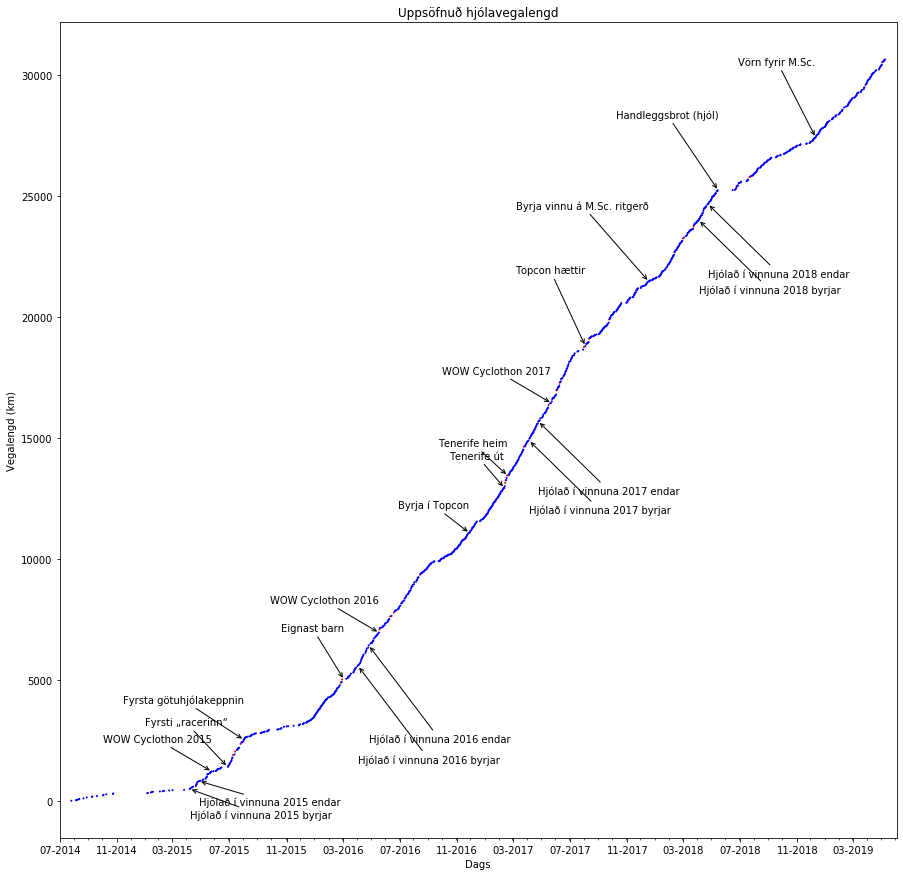

In [4]:
# Select some dates for the chart to start and end. Less chaotic ticks.
start_date = datetime.strptime('2014-07-31', '%Y-%m-%d').date()
end_date = datetime.strptime('2019-07-01', '%Y-%m-%d').date()

# Convert the dates to epoch.
start_unix = time.mktime(start_date.timetuple())
end_unix = time.mktime(end_date.timetuple())

# X and Y axis for the chart.
x = activity_data['unix']
y = activity_data['distance_cumsum']

# Color days red that exceed 100 km.
c = ['red' if x['distance'] > 100 else 'blue' for i, x in activity_data.iterrows()]

# Make a scatter chart.
fig, ax = plt.subplots(figsize=(15, 15))

ax.scatter(x=x, y=y, s=1, c=c)

ax.set_title('Uppsöfnuð hjólavegalengd')
ax.set_xlabel('Dags')
ax.set_ylabel('Vegalengd (km)')

# List some interesting events.
events = [
    # Races
    dict(d='2015-06-22', n='WOW Cyclothon 2015', p=1200, h='right'),
    dict(d='2016-06-15', n='WOW Cyclothon 2016', p=1200, h='right'),
    dict(d='2017-06-20', n='WOW Cyclothon 2017', p=1200, h='right'),
    
    dict(d='2015-08-30', n='Fyrsta götuhjólakeppnin', p=1500, h='right'),
    
    # Cycle to work
    dict(d='2015-05-06', n='Hjólað í vinnuna 2015 byrjar', p=-1200, h='left'),
    dict(d='2015-05-26', n='Hjólað í vinnuna 2015 endar', p=-1000, h='left'),
    dict(d='2016-05-01', n='Hjólað í vinnuna 2016 byrjar', p=-4000, h='left'),
    dict(d='2016-05-24', n='Hjólað í vinnuna 2016 endar', p=-4000, h='left'),
    dict(d='2017-05-03', n='Hjólað í vinnuna 2017 byrjar', p=-3000, h='left'),
    dict(d='2017-05-23', n='Hjólað í vinnuna 2017 endar', p=-3000, h='left'),
    dict(d='2018-05-02', n='Hjólað í vinnuna 2018 byrjar', p=-3000, h='left'),
    dict(d='2018-05-22', n='Hjólað í vinnuna 2018 endar', p=-3000, h='left'),
    
    # Cycle trips
    dict(d='2017-03-11', n='Tenerife út', p=1200, h='right'),
    dict(d='2017-03-18', n='Tenerife heim', p=1200, h='right'),
    
    # Life events
    dict(d='2015-07-26', n='Fyrsti „racerinn“', p=1700, h='right'),
    dict(d='2016-04-01', n='Eignast barn', p=2000, h='right'),
    dict(d='2016-12-26', n='Byrja í Topcon', p=1000, h='right'),
    dict(d='2017-09-01', n='Topcon hættir', p=3000, h='right'),
    dict(d='2018-06-13', n='Handleggsbrot (hjól)', p=3000, h='right'),
    dict(d='2018-01-15', n='Byrja vinnu á M.Sc. ritgerð', p=3000, h='right'),
    dict(d='2019-01-08', n='Vörn fyrir M.Sc.', p=3000, h='right'),
]

# Annotate the chart with these events.
for event in events:
    event_date = datetime.strptime(event['d'], '%Y-%m-%d').date() # Convert to date.
    event_date_unix = time.mktime(event_date.timetuple()) # Convert to time since epoch.
    idx = activity_data['unix'].sub(event_date_unix).abs().idxmin()
    dst = activity_data.loc[idx]['distance_cumsum'] # Locate the closest point to this event.
    pos = dst + event['p'] # Position the label on the chart.
    
    # Add an annotation with the label.
    ax.annotate(event['n'],
                arrowprops=dict(arrowstyle="->"),
                horizontalalignment=event.get('h', 'center'),
                xy=(event_date_unix, dst),
                xytext=(event_date_unix, pos))

# Start and end dates.
ax.set_xlim((start_unix, end_unix))

# Make major ticks on the chart for every 4 months.
major_ticks = []
major_tick_counter = start_date

while major_tick_counter <= end_date:
    major_ticks.append(time.mktime(major_tick_counter.timetuple()))
    major_tick_counter = major_tick_counter + relativedelta(months=4)

ax.xaxis.set_major_locator(plt.FixedLocator(major_ticks)) # Every 4 months
ax.xaxis.set_major_formatter(plticker.FuncFormatter(lambda x, _: datetime.utcfromtimestamp(x).date().strftime('%m-%Y')))

# Make minor ticks on the chart for every month.
minor_ticks = []
minor_tick_counter = start_date

while minor_tick_counter <= end_date:
    minor_ticks.append(time.mktime(minor_tick_counter.timetuple()))
    minor_tick_counter = minor_tick_counter + relativedelta(months=1)

ax.xaxis.set_minor_locator(plt.FixedLocator(minor_ticks)) # Every month

# White background.
ax.set_facecolor((1, 1, 1))

# Save to file.
plt.savefig('cumulative_cycling_distance.png')

# Display in notebook.
plt.show()